<a href="https://colab.research.google.com/github/khmelkoff/TraxRuSummarizer/blob/main/TraxRuSummarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install trax

     |████████████████████████████████| 522kB 5.6MB/s 
     |████████████████████████████████| 215kB 48.3MB/s 
     |████████████████████████████████| 3.4MB 35.7MB/s 
     |████████████████████████████████| 3.8MB 44.7MB/s 
     |████████████████████████████████| 368kB 53.5MB/s 
     |████████████████████████████████| 71kB 7.4MB/s 
     |████████████████████████████████| 1.2MB 44.9MB/s 
     |████████████████████████████████| 1.8MB 26.7MB/s 
     |████████████████████████████████| 890kB 54.1MB/s 
     |████████████████████████████████| 2.9MB 52.1MB/s 


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
# from unicodedata import normalize
import sentencepiece as spm

import trax
from trax import layers as tl
from trax.fastmath import numpy as jnp

%matplotlib inline

In [3]:
import textwrap
wrapper = textwrap.TextWrapper(width=70)

## Load the data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data = pd.read_csv('/content/drive/MyDrive/lenta-ru-news.csv.zip')
data.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18


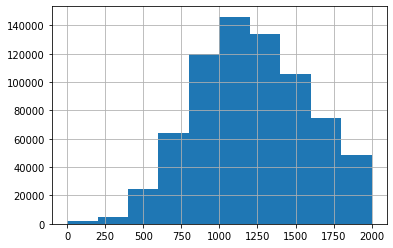

In [6]:
data['text_len'] = [len(x) if not type(x)==float else 0 for x in data.text]
data.text_len[data.text_len < 2000].hist()

In [7]:
# text_full = []  # full text list for train senttence piece tokenizer
text_pairs = [] # paired data for train the model, format: (title, text)
for i in tqdm(range(data.shape[0])):
    if data.iloc[i, 6] >= 200 and data.iloc[i, 6] <= 1900:
        # text_full.append(data.iloc[i, 1] + '\n' + data.iloc[i, 2])
        # list of (article, summary)
        text_pairs.append((data.iloc[i, 2], data.iloc[i, 1]))

# save full text to text file        
# with open('full_text.txt', 'w', encoding='utf-8') as file:
#     file.write('\n'.join(text_full))  

100%|██████████| 800975/800975 [01:09<00:00, 11587.13it/s]


## Load / Train BPE tokenizer

In [8]:
# train tokenizer
# spm.SentencePieceTrainer.train('--input=full_text.txt --pad_id=0 --bos_id=-1 --eos_id=1 --unk_id=2 \
#                                --model_prefix=bpe --vocab_size=32000 --model_type=bpe')
sp = spm.SentencePieceProcessor()
sp.load('/content/drive/MyDrive/bpe.model')

True

In [12]:
s0 = text_pairs[10][0]
text_list = wrapper.wrap(s0[:300])
for line in text_list:
    print(line)

Бывший шеф Службы безопасности президента  Александр  Коржаков,  лидер
Движения  в поддержку армии Виктор Илюхин и руководители ряда других
движений возглавят блок патриотических сил "Русский дом". Выступая
сегодня на пресс-конференции в Москве, руководитель "Союза
соотечественников - "Отчизна" Бор


In [13]:
# tokenizer check
print('encode: text => id:')
print(sp.encode_as_pieces(s0[:300]))
print('')
print(sp.encode_as_ids(s0[:300]))
print('')
print('decode: id => text:')
print(sp.decode_pieces(sp.encode_as_pieces(s0[:300])))
print('')
print(f'Beginning of sentence id: {sp.bos_id()}')
print(f'Pad id: {sp.pad_id()}')
print(f'End of sentence id: {sp.eos_id()}')
print(f'Unknown id: {sp.unk_id()}')
print(f'Vocab size: {sp.vocab_size()}')      

encode: text => id:
['▁Бывший', '▁шеф', '▁Службы', '▁безопасности', '▁президента', '▁Александр', '▁Кор', 'жа', 'ков', ',', '▁лидер', '▁Дви', 'жения', '▁в', '▁поддержку', '▁армии', '▁Виктор', '▁Илю', 'хин', '▁и', '▁руководители', '▁ряда', '▁других', '▁движений', '▁возгла', 'вят', '▁блок', '▁патрио', 'тических', '▁сил', '▁"', 'Русский', '▁дом', '".', '▁Выступая', '▁сегодня', '▁на', '▁пресс', '-', 'конференции', '▁в', '▁Москве', ',', '▁руководитель', '▁"', 'Союза', '▁соотечествен', 'ников', '▁-', '▁"', 'От', 'чи', 'зна', '"', '▁Бор']

[3922, 22029, 13689, 1406, 885, 1868, 3813, 179, 135, 31894, 1693, 12991, 931, 5, 3707, 3297, 4200, 29053, 7513, 18, 12022, 5342, 1484, 21802, 2137, 4556, 7441, 15947, 6245, 1150, 82, 16138, 2866, 301, 16526, 3302, 26, 781, 31910, 5287, 5, 1065, 31894, 4424, 82, 24744, 10949, 451, 246, 82, 8233, 100, 285, 31905, 9384]

decode: id => text:
Бывший шеф Службы безопасности президента Александр Коржаков, лидер Движения в поддержку армии Виктор Илюхин и руководите

In [14]:
uid = 18298
spiece = "\u2581Саха"
unknown = "_НЕИЗВЕСТНОСТЬ_"

# id <=> piece conversion
print(f'SentencePiece for ID {uid}: {sp.id_to_piece(uid)}')
print(f'ID for Sentence Piece {spiece}: {sp.piece_to_id(spiece)}')

# returns 0 for unknown tokens (we can change the id for UNK)
print(f'ID for unknown text {unknown}: {sp.piece_to_id(unknown)}')

SentencePiece for ID 18298: ▁Саха
ID for Sentence Piece ▁Саха: 18298
ID for unknown text _НЕИЗВЕСТНОСТЬ_: 2


In [15]:
# vocab's head and tail test
print('\nId\tSentP\tControl?')
print('------------------------')
for uid in range(7):
    print(uid, sp.id_to_piece(uid), sp.is_control(uid), sep='\t')
    
for uid in range(sp.vocab_size()-7,sp.vocab_size()):
    print(uid, sp.id_to_piece(uid), sp.is_control(uid), sep='\t')


Id	SentP	Control?
------------------------
0	<pad>	True
1	</s>	True
2	<unk>	False
3	▁п	False
4	ст	False
5	▁в	False
6	▁с	False
31993	V	False
31994	x	False
31995	J	False
31996	z	False
31997	K	False
31998	U	False
31999	X	False


## Data: preprocess and create generators

In [16]:
# inintial shuffling
random.shuffle(text_pairs)
margin = int(len(text_pairs)*0.9)
train_text_pairs = text_pairs[:margin]
print('train cases: ', len(train_text_pairs))
eval_text_pairs = text_pairs[margin:]
print('eval cases: ', len(eval_text_pairs))

train cases:  630781
eval cases:  70087


In [17]:
def data_generator(data, shuffle=True):
    '''
      Input: 
        data - list containing tuples (article, summary)
        shuffle - If True: shuffle the data order
      Output:
        a tuple containing 2 elements:
        article
        summary
    '''
    
    data_lng = len(data) # len(data)
    index_list = [*range(data_lng)] # Create a list with the ordered indexes of sample data
    
    index = 0 # Start with the first element
    while True:
        # Wrap the index each time that we reach the end of the list
        if index >= data_lng:
            index = 0

        if shuffle:
            random.shuffle(index_list) # re-shuffle the order
            
        sample = data[index_list[index]]
        index += 1
        yield(sample)

# create data streams
def train_data_stream():
    return data_generator(train_text_pairs, shuffle=True)

def eval_data_stream():
    return data_generator(eval_text_pairs, shuffle=True)        

In [18]:
def tokenize(input_str, EOS=1):
    """Input str to features dict, ready for inference"""
  
    # Use the trax.data.tokenize method. It takes streams and returns streams,
    # we get around it by making a 1-element stream with `iter`.
    inputs =  next(trax.data.tokenize(iter([input_str]),
                                      vocab_type='sentencepiece',
                                      vocab_dir='/content/drive/MyDrive/',
                                      vocab_file='bpe.model'),
                                      
                   )
    
    # Mark the end of the sentence with EOS
    return list(inputs) + [EOS]

def detokenize(integers):
    """List of ints to str"""
  
    s = trax.data.detokenize(integers,
                             vocab_type='sentencepiece',
                             vocab_dir='/content/drive/MyDrive/',
                             vocab_file='bpe.model')
    
    return s

In [19]:
detokenize(tokenize('Сведения о пассажирах на всех видах транспорта, где используются именные проездные билеты', EOS=1))

'Сведения о пассажирах на всех видах транспорта, где используются именные проездные билеты'

In [20]:
# Special tokens
SEP = 0 # Padding or separator token
EOS = 1 # End of sentence token

# Concatenate tokenized inputs and targets using 0 as separator.
def preprocess(stream):
    for (article, summary) in stream:
        joint = np.array(list(article) + [EOS, SEP] + list(summary) + [EOS])
        mask = [0] * (len(list(article)) + 2) + [1] * (len(list(summary)) + 1) 
        yield joint, joint, np.array(mask)

# You can combine a few data preprocessing steps into a pipeline like this.
input_pipeline = trax.data.Serial(
    # Tokenizes
    trax.data.Tokenize(vocab_type='sentencepiece',
                       vocab_dir='/content/drive/MyDrive/',
                       vocab_file='bpe.model'),
    # Uses function defined above
    preprocess,
)

# Apply preprocessing to data streams.
train_stream = input_pipeline(train_data_stream())
eval_stream = input_pipeline(eval_data_stream())

In [21]:
train_input, train_target, train_mask = next(train_stream)
# assert sum((train_input - train_target)**2) == 0  # They are the same in Language Model (LM).

In [22]:
# check pad (id:0) and sep/eos (id:1)
print(train_input[-20:])

[ 1742   320    26 14448  6608  3049 31898     1     0 12439 12944   530
  2566  3947    11  1576  2208  1095  9526     1]


## Batching and Bucketing 

In [23]:
# batch of 8 sentences of length < 256 , 4 of length < 512....
boundaries =  [256, 512, 1024]
batch_sizes = [8, 4, 2, 1]

# Create the streams.
train_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes)(train_stream)

eval_batch_stream = trax.data.BucketByLength(
    boundaries, batch_sizes)(eval_stream)

In [24]:
input_batch, _, mask_batch = next(train_batch_stream)

# Shape of the input_batch
input_batch.shape

(4, 512)

In [25]:
# check autopadding endig of sample
# 1, 0, <not 0 digit>... - end of article and start of summary
input_batch[0]

array([ 5890, 15295, 12298,  3130,  1798,   280, 11520, 19031,  4946,
         297,  3357,  6467, 31897, 15934,  4838,   435,  9224,  3931,
       31898,    61,  2505,   868,  8241, 13901,    26,    37,    53,
         116,  1099, 31898,  1767, 31894,    78,  5057,  2191,  1501,
       29944,  6257,   246,     5,  6495,   189,    18, 25106,  1671,
         517,  1146,   246,    59,  4726,   171,   273,  2797,   205,
       31898, 19284,  3087,  2259, 18944, 12601,   246,   886, 31898,
       31817, 31914,  9589, 31898, 11092,    18,  7173,  2282, 10499,
       20655,   694,    39,   879,   660,   132, 31876,    18,  8469,
         727,  1220, 31898,   732,  9246, 19031,    39,   107,  1994,
         575,  2195, 21252,  3470,  1828,   274,  1475,  2797,  4733,
       31898,  1176,   692,    82, 20622,    15, 31905,     5, 20212,
         189, 15991,   205,  8241,  7590, 21712,  7295,   100,   656,
       31894, 27342,  5848,   515,  3087, 13411,  1686,   249, 31893,
       28283, 31898,

## Transformer Model

### Positional encoder

In [26]:
def PositionalEncoder(vocab_size, d_model, dropout, max_len, mode):
    """Returns a list of layers that: 
    1. takes a block of text as input, 
    2. embeds the words in that text, and 
    3. adds positional encoding, 
       i.e. associates a number in range(max_len) with 
       each word in each sentence of embedded input text 
    
    The input is a list of tokenized blocks of text
    
    Args:
        vocab_size (int): vocab size.
        d_model (int):  depth of embedding.
        dropout (float): dropout rate (how much to drop out).
        max_len (int): maximum symbol length for positional encoding.
        mode (str): 'train' or 'eval'.
    """
    # Embedding inputs and positional encoder
    return [ 
        # Add embedding layer of dimension (vocab_size, d_model)
        tl.Embedding(vocab_size, d_model),  
        # Use dropout with rate and mode specified
        tl.Dropout(rate=dropout, mode=mode), 
        # Add positional encoding layer with maximum input length and mode specified
        tl.PositionalEncoding(max_len=max_len, mode=mode)] 

### Feed-Forward layer

In [27]:
def FeedForward(d_model, d_ff, dropout, mode, ff_activation):
    """Returns a list of layers that implements a feed-forward block.

    The input is an activation tensor.

    Args:
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        dropout (float): dropout rate (how much to drop out).
        mode (str): 'train' or 'eval'.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        list: list of trax.layers.combinators.Serial that maps an activation tensor to an activation tensor.
    """
    
    # Create feed-forward block (list) with two dense layers with dropout and input normalized
    return [ 
        # Normalize layer inputs
        tl.LayerNorm(), 
        # Add first feed forward (dense) layer (don't forget to set the correct value for n_units)
        tl.Dense(d_ff), 
        # Add activation function passed in as a parameter (you need to call it!)
        ff_activation(),  # Generally ReLU
        # Add dropout with rate and mode specified (i.e., don't use dropout during evaluation)
        tl.Dropout(rate=dropout, mode=mode), 
        # Add second feed forward layer (don't forget to set the correct value for n_units)
        tl.Dense(d_model), 
        # Add dropout with rate and mode specified (i.e., don't use dropout during evaluation)
        tl.Dropout(rate=dropout, mode=mode) 
    ]

### Decoder Block

In [28]:
def DecoderBlock(d_model, d_ff, n_heads,
                 dropout, mode, ff_activation):
    """Returns a list of layers that implements a Transformer decoder block.

    The input is an activation tensor.

    Args:
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        n_heads (int): number of attention heads.
        dropout (float): dropout rate (how much to drop out).
        mode (str): 'train' or 'eval'.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        list: list of trax.layers.combinators.Serial that maps an activation tensor to an activation tensor.
    """
        
    # Add list of two Residual blocks: the attention with normalization and dropout and feed-forward blocks
    return [
      tl.Residual(
          # Normalize layer input
          tl.LayerNorm(), 
          # Add causal attention 
          tl.CausalAttention(d_model, n_heads=n_heads, dropout=dropout, mode=mode) 
        ),
      tl.Residual(
          # Add feed-forward block
          # We don't need to normalize the layer inputs here. The feed-forward block takes care of that for us.
          FeedForward(d_model, d_ff, dropout, mode, ff_activation)
        ),
      ]

### Trnsformer (decoder)

In [30]:
def SumTransformer(vocab_size=32000,
                  d_model=512,
                  d_ff=2048,
                  n_layers=6,
                  n_heads=8,
                  dropout=0.1,
                  max_len=4096,
                  mode='train',
                  ff_activation=tl.Relu):
    """Returns a Transformer language model.

    The input to the model is a tensor of tokens. (This model uses only the
    decoder part of the overall Transformer.)

    Args:
        vocab_size (int): vocab size.
        d_model (int):  depth of embedding.
        d_ff (int): depth of feed-forward layer.
        n_layers (int): number of decoder layers.
        n_heads (int): number of attention heads.
        dropout (float): dropout rate (how much to drop out).
        max_len (int): maximum symbol length for positional encoding.
        mode (str): 'train', 'eval' or 'predict', predict mode is for fast inference.
        ff_activation (function): the non-linearity in feed-forward layer.

    Returns:
        trax.layers.combinators.Serial: A Transformer language model as a layer that maps from a tensor of tokens
        to activations over a vocab set.
    """
    
    # Create stack (list) of decoder blocks with n_layers with necessary parameters
    decoder_blocks = [ 
        DecoderBlock(d_model, d_ff, n_heads, dropout, mode, ff_activation) for _ in range(n_layers)] 

    # Create the complete model as written in the figure
    return tl.Serial(
        # Use teacher forcing (feed output of previous step to current step)
        tl.ShiftRight(mode=mode), 
        # Add embedding inputs and positional encoder
        PositionalEncoder(vocab_size, d_model, dropout, max_len, mode),
        # Add decoder blocks
        decoder_blocks, 
        # Normalize layer
        tl.LayerNorm(), 

        # Add dense layer of vocab_size (since need to select a word to translate to)
        # (a.k.a., logits layer. Note: activation already set by ff_activation)
        tl.Dense(vocab_size), 
        # Get probabilities with Logsoftmax
        tl.LogSoftmax() 
    )

In [32]:
print(SumTransformer(n_layers=1))

Serial[
  Serial[
    ShiftRight(1)
  ]
  Embedding_32000_512
  Dropout
  PositionalEncoding
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Serial[
          Serial[
            Serial[
              Branch_out3[
                [Dense_512, Serial[
                  SplitIntoHeads
                ]]
                [Dense_512, Serial[
                  SplitIntoHeads
                ]]
                [Dense_512, Serial[
                  SplitIntoHeads
                ]]
              ]
              DotProductCausalAttention_in3
              Serial[
                MergeHeads
              ]
              Dense_512
            ]
          ]
        ]
      ]
    ]
    Add_in2
  ]
  Serial[
    Branch_out2[
      None
      Serial[
        LayerNorm
        Dense_2048
        Serial[
          Relu
        ]
        Dropout
        Dense_512
        Dropout
      ]
    ]
    Add_in2
  ]
  LayerNorm
  Dense_32000
  LogSoftmax
]


## Training

In [33]:
from trax.supervised import training

def training_loop(SumTransformer, train_gen, eval_gen, output_dir = "~/model"):
    '''
    Input:
        SumTransformer (trax.layers.combinators.Serial): The transformer model.
        train_gen (generator): Training stream of data.
        eval_gen (generator): Evaluation stream of data.
        output_dir (str): folder to save your file.
        
    Returns:
        trax.supervised.training.Loop: Training loop.
    '''
    output_dir = os.path.expanduser(output_dir)  # trainer is an object
    lr_schedule = trax.lr.warmup_and_rsqrt_decay(n_warmup_steps=1000, max_value=0.01)

    train_task = training.TrainTask( 
      labeled_data=train_gen, # The training generator
      loss_layer=tl.CrossEntropyLoss(), # Loss function 
      optimizer=trax.optimizers.Adam(0.01), # Optimizer 
      lr_schedule=lr_schedule,
      n_steps_per_checkpoint=10
    )

    eval_task = training.EvalTask( 
      labeled_data=eval_gen, # The evaluation generator
      metrics=[tl.CrossEntropyLoss(), tl.Accuracy()] # CrossEntropyLoss and Accuracy
    )

    loop = training.Loop(SumTransformer(d_model=4,
                                       d_ff=16,
                                       n_layers=1,
                                       n_heads=2,
                                       mode='train'),
                         train_task,
                         eval_tasks=[eval_task],
                         output_dir=output_dir)
    
    return loop

In [ ]:
# Should take around 1.5 minutes
!rm -f ~/model/model.pkl.gz
loop = training_loop(TransformerLM, train_batch_stream, eval_batch_stream)
loop.run(10)